<a href="https://colab.research.google.com/github/con11235/covid19_visualize/blob/master/%EA%B0%90%EC%97%BC%EC%9D%98_%EC%8B%9C%EC%B4%88%EB%8A%94_%EB%88%84%EA%B5%AC%EC%9D%B8%EA%B0%80(%EC%A7%84%ED%96%89%EC%A4%91).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
!pip install python-igraph
!pip install plotly

In [86]:
import pandas as pd
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 
!apt -qq -y install fonts-nanum
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [87]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### PatientInfo 데이터를 활용해서, 감염을 퍼트린 시초(이후 전파자라고 칭함)를 알아보자.


In [7]:
patientInfo = pd.read_csv('/content/gdrive/My Drive/dacon/COVID_19/PatientInfo.csv')

In [8]:
patientInfo.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,서울,강서구,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,서울,중랑구,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,서울,종로구,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,서울,마포구,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,서울,성북구,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [9]:
#infection_case가 contact with patient 인 경우만 분리
patient_who_infected_by_others = patientInfo[patientInfo['infection_case'] == 'contact with patient'].reset_index().drop(["index"], axis = 1)
patient_who_infected_by_others = patient_who_infected_by_others[['patient_id','sex','age','country','province','city','infection_case','infected_by']]
patient_who_infected_by_others['province_city'] = patient_who_infected_by_others['province'] + ' ' + patient_who_infected_by_others['city']
patient_who_infected_by_others = patient_who_infected_by_others.drop(["province","city"], axis = 1)
patient_who_infected_by_others.head()

,patient_id,sex,age,country,infection_case,infected_by,province_city
0,1000000003,male,50s,Korea,contact with patient,2002000001,서울 종로구
1,1000000005,female,20s,Korea,contact with patient,1000000002,서울 성북구
2,1000000006,female,50s,Korea,contact with patient,1000000003,서울 종로구
3,1000000007,male,20s,Korea,contact with patient,1000000003,서울 종로구
4,1000000010,female,60s,Korea,contact with patient,1000000003,서울 성북구


In [10]:
region = pd.read_csv('/content/gdrive/My Drive/dacon/COVID_19/Region.csv')
region.head()

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,서울,서울,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,서울,강남구,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,서울,강동구,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,서울,강북구,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,서울,강서구,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080


In [11]:
region = region[['code','province','city']]
region.head()

,code,province,city
0,10000,서울,서울
1,10010,서울,강남구
2,10020,서울,강동구
3,10030,서울,강북구
4,10040,서울,강서구


In [12]:
region['province_city'] = ''
for i in range(len(region)):
  if region['province'][i] == region['city'][i]:
    region['province_city'][i] = region['province'][i]
  else:
    region['province_city'][i] = region['province'][i] +' '+region['city'][i]
region = region[['code','province_city']]
region.head()

,code,province_city
0,10000,서울
1,10010,서울 강남구
2,10020,서울 강동구
3,10030,서울 강북구
4,10040,서울 강서구


In [13]:
patient_who_infected_by_others['infected_by'].isnull().sum() / patient_who_infected_by_others['infected_by'].size

0.23229813664596274

In [14]:
patient_who_infected_by_others = patient_who_infected_by_others.dropna(axis = 0)
patient_who_infected_by_others.head()

,patient_id,sex,age,country,infection_case,infected_by,province_city
0,1000000003,male,50s,Korea,contact with patient,2002000001,서울 종로구
1,1000000005,female,20s,Korea,contact with patient,1000000002,서울 성북구
2,1000000006,female,50s,Korea,contact with patient,1000000003,서울 종로구
3,1000000007,male,20s,Korea,contact with patient,1000000003,서울 종로구
4,1000000010,female,60s,Korea,contact with patient,1000000003,서울 성북구


In [15]:
patient_who_infected_by_others = patient_who_infected_by_others.reset_index().drop(['index'], axis = 1)

In [16]:
patient_who_infected_by_others.head()
trace = dict()
for i in range(len(patient_who_infected_by_others)):
  infected = patient_who_infected_by_others['infected_by'][i]
  patient = patient_who_infected_by_others['patient_id'][i]
  if infected in trace:
    trace[infected].append(patient)
  else:
    trace[infected] = [patient]


In [17]:
getMax = 0
for key, value in trace.items():
  if len(value) > getMax:
    getMax = len(value)
getMax = getMax * 2 + 1

In [18]:
for key in trace:
  if len(trace[key]) < getMax:
    while len(trace[key]) < getMax:
      trace[key].append(0) 

size = []
for key,value in trace.items():
  size.append(len(value))


trace_df = pd.DataFrame(trace)
trace_df = trace_df.T
trace_df = trace_df.reset_index()
trace_df.rename(columns={'index':'beginning'}, inplace = True)
trace_df.to_csv('/content/gdrive/My Drive/dacon/trace_testset.csv')


In [19]:
test_trace_df = pd.read_csv('/content/gdrive/My Drive/dacon/trace_testset.csv')
test_trace_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [20]:
test_trace_df.head()

,beginning,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102
0,2002000001,1000000003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000000002,1000000005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1000000003,1000000006,1000000007,1000000010,1000000017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000000017,1000000013,1000000016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1000000013,1000000014,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


전파자가 같은 값들을 해당 전파자에 넣는다.  
결국, 전파자가 같은 감염자들이 key를 전파자로 하여 value에 모두 모이게 된다.  
이를 다시 Dataframe으로 나타낸다.

In [21]:
# for i in range(len(test_trace_df)):
i = 0
while i < len(test_trace_df):
  for j in range(103):
    beginning = list(test_trace_df['beginning'][:])
    if test_trace_df[str(j)][i] == 0:
      continue
    if test_trace_df[str(j)][i] in beginning:
      idx = beginning.index(test_trace_df[str(j)][i])
      tmp = list(test_trace_df.loc[idx])
      for k in range(len(tmp)):
        if tmp[k] == 0:
          tmp = tmp[1:k]
          break
      for l in range(len(test_trace_df.loc[idx])):
        if test_trace_df.loc[i][l] == 0:
          test_trace_df.loc[i][l:l+len(tmp)] = tmp
          test_trace_df.drop([idx], inplace = True)
          test_trace_df = test_trace_df.reset_index()
          test_trace_df.drop(["index"],axis= 1,inplace=True)
          break
  i += 1

모두 0을 갖는 열을 삭제한다.  
처음에 각 행의 길이를 getMax * 2 + 1로 설정한 이유는, getMax 길이를 갖는 전파자가 다른 전파자에 의해 감염된 경우일 수도 있기 때문에 가질 수 있는 최대 길이의 +1을 해주었다.  

In [22]:
dropcol = []
for i in range(0,103):
  tmp = list(test_trace_df[str(i)])
  if len(set(tmp)) == 1 and tmp[0] == 0:
    dropcol.append(i)

while dropcol:
  j = dropcol.pop()
  test_trace_df.drop([str(j)],axis=1,inplace= True)


test_trace_df.head()

,beginning,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
0,2002000001,1000000003,1000000006,1000000007,1000000010,1000000017,1000000013,1000000016,1000000014,1000000021,2000000019,1000000019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000000002,1000000005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1000000031,1000000033,1000000034,1000000037,1000000045,1000000067,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1000000041,1000000046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1000000047,1000000064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
test_trace_df.to_csv('/content/gdrive/My Drive/dacon/update_trace_testset_drop_all_zero.csv')

전파자들의 정보를 알아보기 위해, dictionary 형태로 가져온 후 Df로 변경하는 과정을 거쳤다. 이 때 가져오는 정보는 성별, 나이대, 지역, 감염 원인이다.

In [24]:
bg = list(test_trace_df['beginning'])

info_about_beginning = dict()
for p_id in bg:
  for i in range(len(patientInfo)):
    if int(patientInfo['patient_id'][i]) == int(p_id):
      info_about_beginning[p_id] = [patientInfo['sex'][i],patientInfo['age'][i],patientInfo['province'][i], patientInfo['city'][i], patientInfo['infection_case'][i]]
      break

In [25]:
info_about_beginning_df = pd.DataFrame(info_about_beginning)
info_about_beginning_df = info_about_beginning_df.T
info_about_beginning_df = info_about_beginning_df.reset_index()
info_about_beginning_df.rename(columns={'index':'beginning'}, inplace = True)
info_about_beginning_df.columns = ["beginning","sex","age","province","city","infection_case"]
info_about_beginning_df.head()

,beginning,sex,age,province,city,infection_case
0,1000000002,male,30s,서울,중랑구,overseas inflow
1,1000000031,male,50s,서울,송파구,etc
2,1000000041,male,50s,서울,강동구,etc
3,1000000047,male,20s,서울,강남구,Shincheonji Church
4,1000000068,female,20s,서울,강남구,etc


하지만 아래 check를 통해 확인할 수 있듯이, 전파자임에도 불구하고 '접촉'을 통해 감염된 환자들이 37명이나 존재했다.

In [26]:
check = info_about_beginning_df[info_about_beginning_df['infection_case'] == 'contact with patient']
print(len(check))
check.head()

37


,beginning,sex,age,province,city,infection_case
5,1000000111,male,30s,서울,강북구,contact with patient
6,1000000115,female,50s,서울,양천구,contact with patient
9,1000000108,male,40s,서울,기타,contact with patient
21,1000000264,male,40s,서울,강서구,contact with patient
49,1100000002,female,50s,부산,해운대구,contact with patient


37명은, 전체 전파자 수 대비하여 보았을 때 13% 정도이다.

In [27]:
print(len(check)/len(info_about_beginning_df))

0.13405797101449277


In [28]:
import collections
infection_case_list = list(info_about_beginning_df['infection_case'])
infection_case_list = collections.Counter(infection_case_list)
infection_most_common = list(infection_case_list.most_common(15))

In [29]:
tmp = dict()
for i in range(len(infection_most_common)):
  key = infection_most_common[i][0]
  value = infection_most_common[i][1]
  if type(key) is float:
    key = 'Unknown'
  tmp[key] = value
print(tmp)

{'etc': 103, 'overseas inflow': 52, 'contact with patient': 37, 'gym facility in Cheonan': 14, 'Shincheonji Church': 12, 'Unknown': 11, 'Itaewon Clubs': 11, 'Coupang Logistics Center': 8, 'Dongan Church': 5, 'Onchun Church': 5, 'Guro-gu Call Center': 4, 'Dunsan Electronics Town': 4, 'Orange Town': 2, 'gym facility in Sejong': 1, 'Ministry of Oceans and Fisheries': 1}


In [30]:
infection_most_common_df = pd.DataFrame(tmp, index = (0,len(tmp)))
infection_most_common_df = infection_most_common_df.T
infection_most_common_df.drop([15],axis=1,inplace=True)
infection_most_common_df = infection_most_common_df.reset_index()
infection_most_common_df.columns = ["infection case","number of cases"]
infection_most_common_df

,infection case,number of cases
0,etc,103
1,overseas inflow,52
2,contact with patient,37
3,gym facility in Cheonan,14
4,Shincheonji Church,12
5,Unknown,11
6,Itaewon Clubs,11
7,Coupang Logistics Center,8
8,Dongan Church,5
9,Onchun Church,5


In [31]:
infection_most_common_df.set_index("infection case")

,number of cases
infection case,
etc,103
overseas inflow,52
contact with patient,37
gym facility in Cheonan,14
Shincheonji Church,12
Unknown,11
Itaewon Clubs,11
Coupang Logistics Center,8
Dongan Church,5


연쇄 감염을 일으킨 원인 Top 15

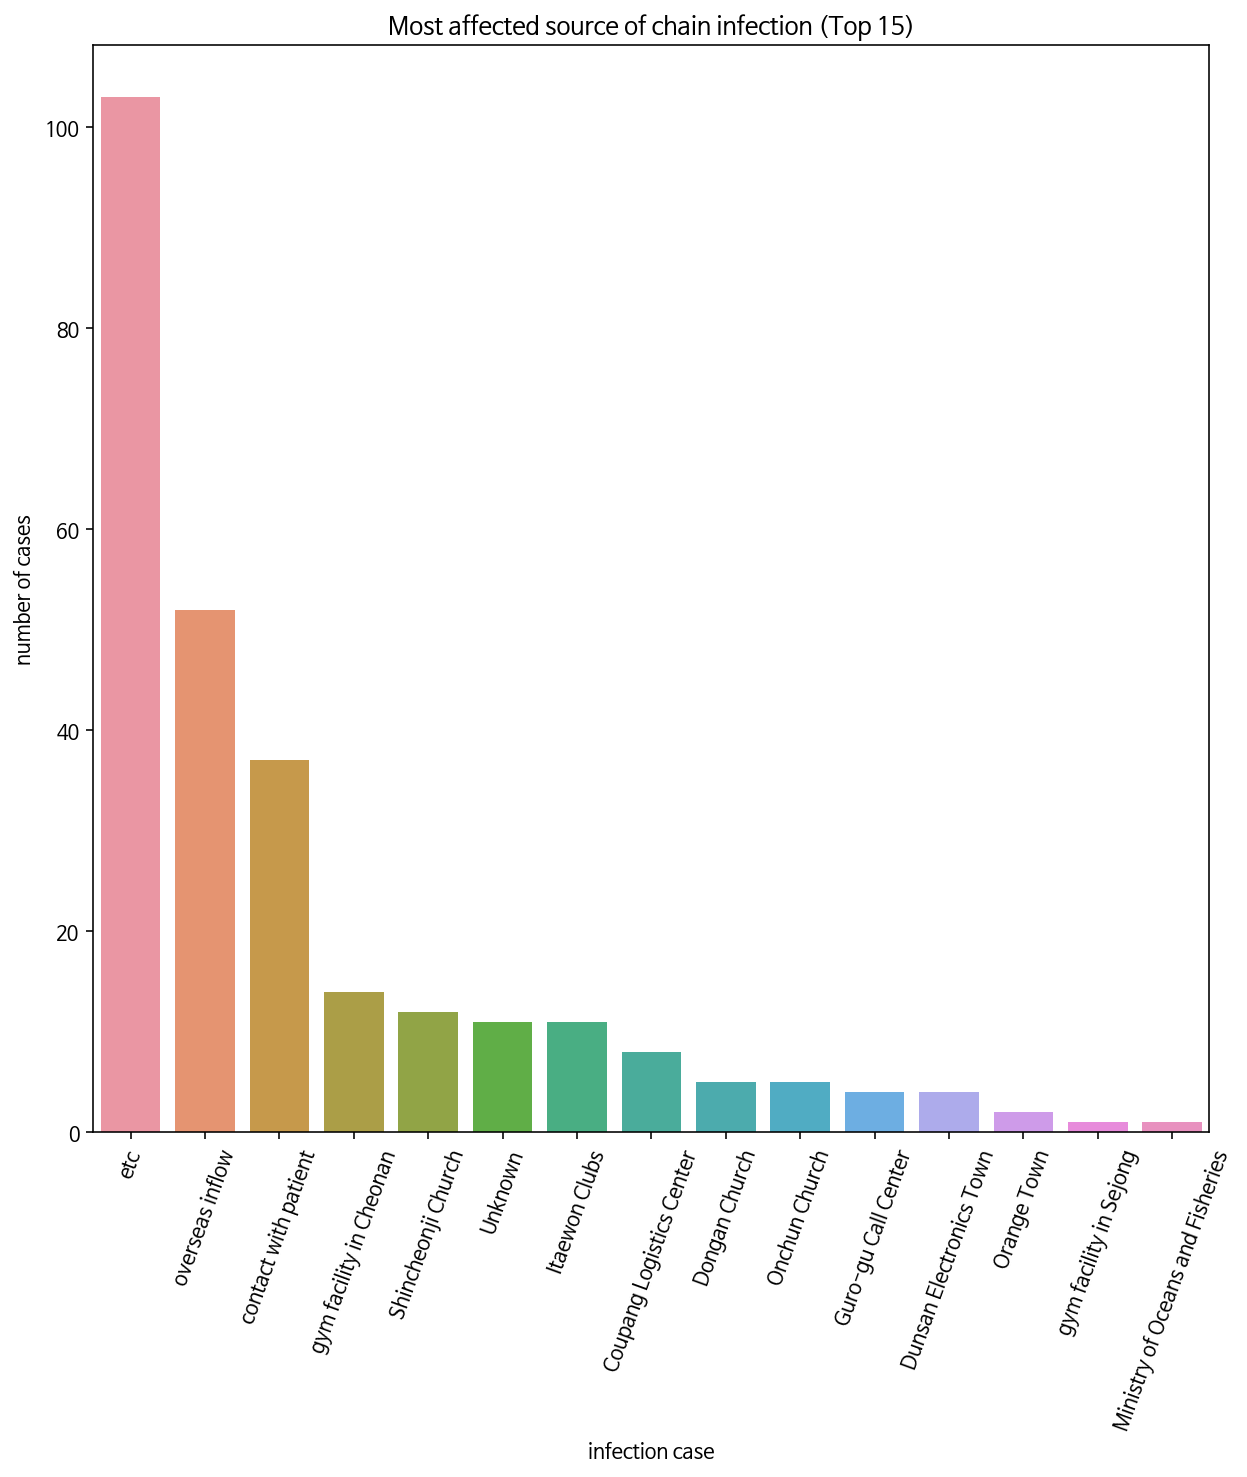

In [91]:
sns.barplot(x='infection case',y='number of cases',data=infection_most_common_df)
plt.title('Most affected source of chain infection (Top 15)')
plt.xticks(rotation=70)
plt.show()


# fig=px.bar(infection_most_common_df,x='infection case',y='number of cases')
# fig.update_layout(
#     title={
#         'text': "Most affected source of chain infection (Top 15)",
#         'y':1,
#         'x':0.5,
#         'xanchor': 'center',
#         'yanchor': 'top'})
# fig.show()

In [33]:
info_about_beginning_df['location'] = info_about_beginning_df['province'] + ' ' + info_about_beginning_df['city']

In [34]:
info_about_beginning_df.drop(["province","city"], axis = 1, inplace=True)

In [35]:
info_about_beginning_df.head()

,beginning,sex,age,infection_case,location
0,1000000002,male,30s,overseas inflow,서울 중랑구
1,1000000031,male,50s,etc,서울 송파구
2,1000000041,male,50s,etc,서울 강동구
3,1000000047,male,20s,Shincheonji Church,서울 강남구
4,1000000068,female,20s,etc,서울 강남구


In [36]:
infection_location = info_about_beginning_df[['location']]
infection_location['count'] = 1
infection_location = infection_location.groupby(['location']).sum().reset_index()
infection_location

,location,count
0,경기도 고양시,3
1,경기도 광주,2
2,경기도 구리시,2
3,경기도 군포시,2
4,경기도 김포시,1
...,...,...
91,충청남도 아산시,4
92,충청남도 천안시,21
93,충청북도 괴산,1
94,충청북도 청주시,1


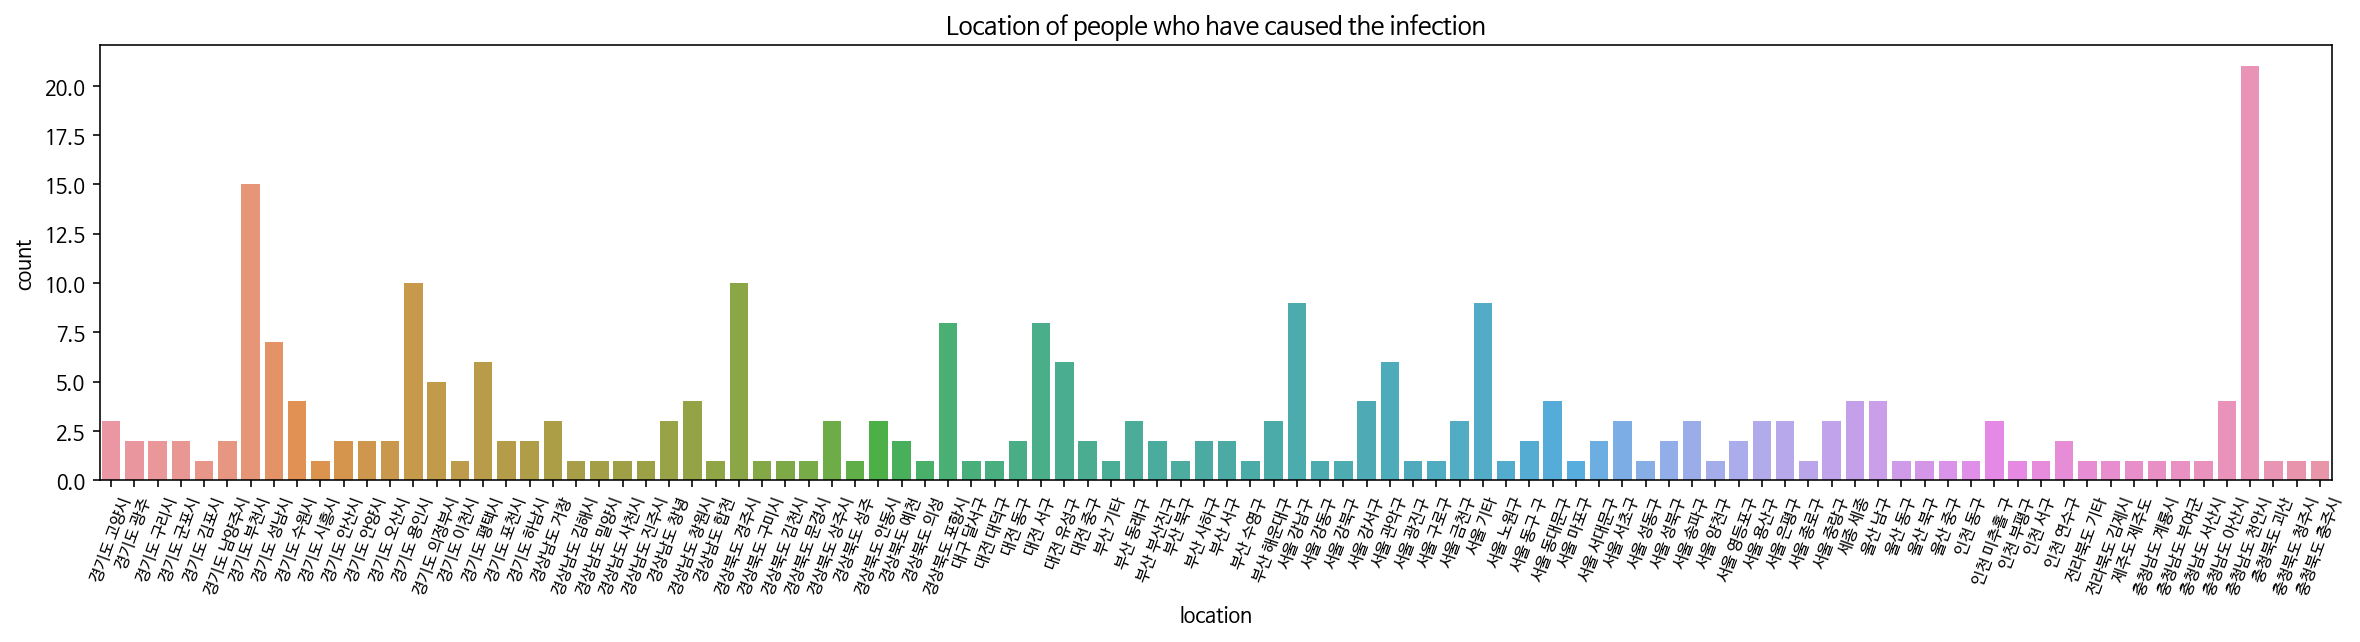

In [92]:
plt.figure(figsize=(20,4)) 
sns.barplot(x='location',y='count',data=infection_location)

plt.title('Location of people who have caused the infection')
plt.xticks(rotation=70, fontsize = 8)
plt.show()

In [94]:
infection_location.sort_values(by='count', ascending=False, inplace= True)
infection_location.head()

,location,count
92,충청남도 천안시,21
6,경기도 부천시,15
13,경기도 용인시,10
27,경상북도 경주시,10
51,서울 강남구,9


전파자의 위치는 **충청남도 천안시, 경기도 부천시, 경기도 용인시, 경상북도 경주시, 서울 강남구** 가 Top 5 였다.

In [95]:
patient_who_infected_by_others.head()

,patient_id,sex,age,country,infection_case,infected_by,province_city
0,1000000003,male,50s,Korea,contact with patient,2002000001,서울 종로구
1,1000000005,female,20s,Korea,contact with patient,1000000002,서울 성북구
2,1000000006,female,50s,Korea,contact with patient,1000000003,서울 종로구
3,1000000007,male,20s,Korea,contact with patient,1000000003,서울 종로구
4,1000000010,female,60s,Korea,contact with patient,1000000003,서울 성북구


접촉자들의 위치 순위를 알아보기 위해서 앞선 test_trace_df의 beginning에 속해있는 사람들을 제외한 patient_who_infected_by_others를 만든다.

In [99]:
bg = list(test_trace_df['beginning'])
p_id = list(patient_who_infected_by_others['patient_id'])
remove_idx = []
for p in bg:
  if p in p_id:
    idx = p_id.index(p)
    remove_idx.append(idx)


infected_by_others_remove_bg = patient_who_infected_by_others
for idx in remove_idx:
  infected_by_others_remove_bg.drop([idx], inplace=True)

infected_by_others_remove_bg.head()

,patient_id,sex,age,country,infection_case,infected_by,province_city
0,1000000003,male,50s,Korea,contact with patient,2002000001,서울 종로구
1,1000000005,female,20s,Korea,contact with patient,1000000002,서울 성북구
2,1000000006,female,50s,Korea,contact with patient,1000000003,서울 종로구
3,1000000007,male,20s,Korea,contact with patient,1000000003,서울 종로구
4,1000000010,female,60s,Korea,contact with patient,1000000003,서울 성북구


In [100]:
infected_by_others_remove_bg_loc = infected_by_others_remove_bg[['province_city']]
infected_by_others_remove_bg_loc['count'] = 1
infected_by_others_remove_bg_loc = infected_by_others_remove_bg_loc.groupby(['province_city']).sum().reset_index()
infected_by_others_remove_bg_loc.head()

,province_city,count
0,경기도 고양시,10
1,경기도 광명시,10
2,경기도 광주,14
3,경기도 구리시,1
4,경기도 군포시,26


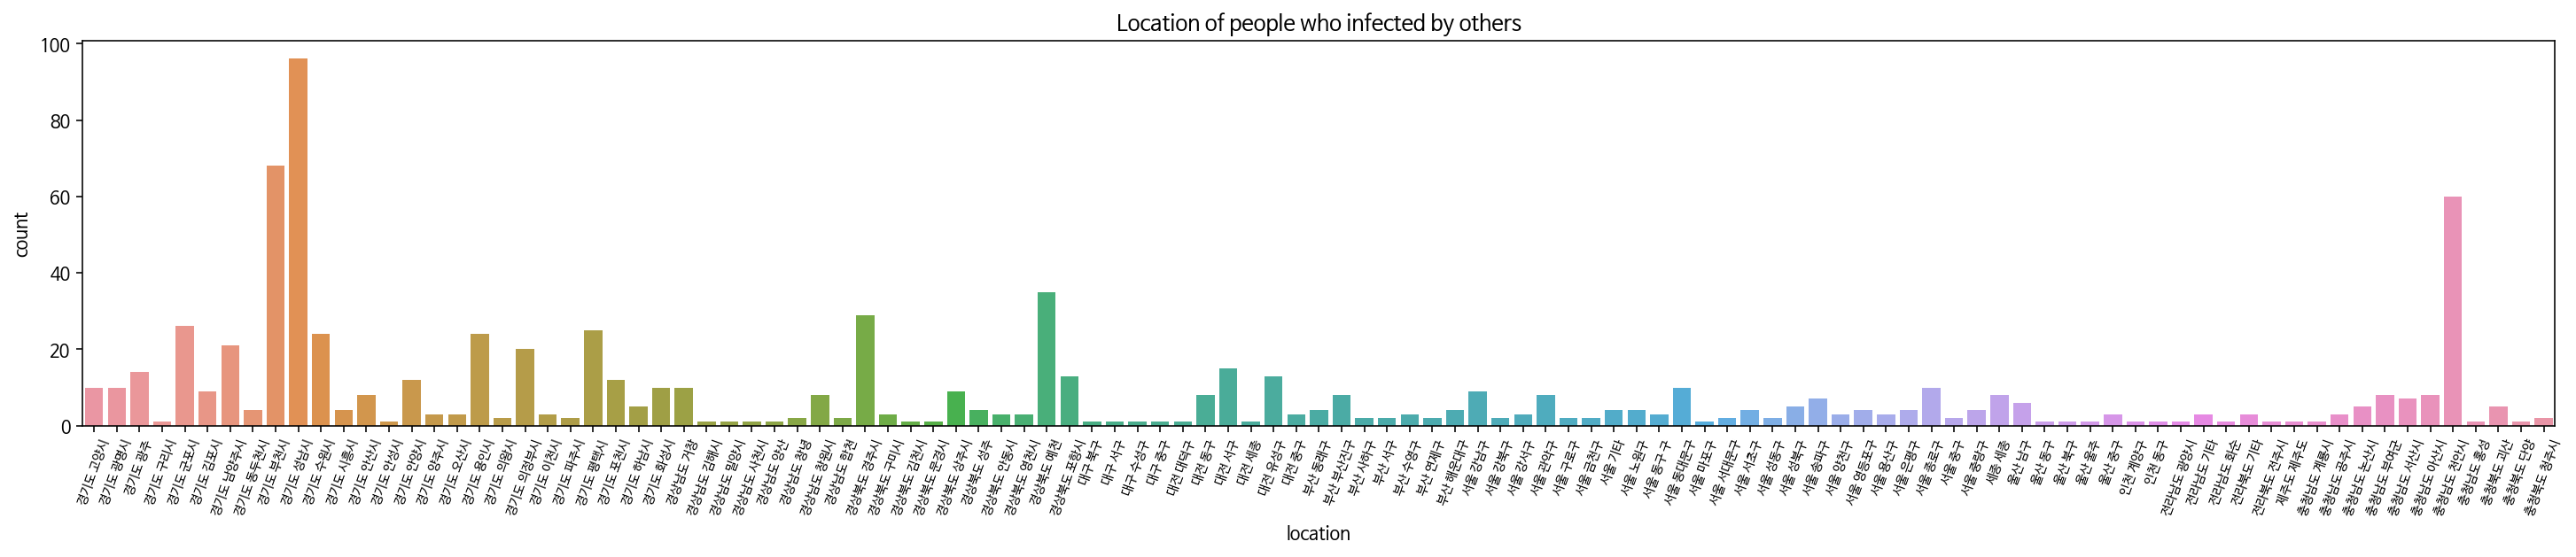

In [103]:
plt.figure(figsize=(25,4)) 
sns.barplot(x='province_city',y='count',data=infected_by_others_remove_bg_loc)

plt.title('Location of people who infected by others')
plt.xticks(rotation=70, fontsize = 7)
plt.xlabel('location')
plt.show()

In [104]:
infected_by_others_remove_bg_loc.sort_values(by='count', ascending=False, inplace= True)
infected_by_others_remove_bg_loc.head()

,province_city,count
9,경기도 성남시,96
8,경기도 부천시,68
104,충청남도 천안시,60
42,경상북도 예천,35
34,경상북도 경주시,29


In [107]:
infection_location.columns = ["location","Number of people who have infected others"]
infected_by_others_remove_bg_loc.columns = ["location","Number of people who infected by others"]
infection_merge = pd.merge(infection_location, infected_by_others_remove_bg_loc, how='left',on='location')
infection_merge.head()

,location,Number of people who have infected others,Number of people who infected by others
0,충청남도 천안시,21,60.0
1,경기도 부천시,15,68.0
2,경기도 용인시,10,24.0
3,경상북도 경주시,10,29.0
4,서울 강남구,9,9.0


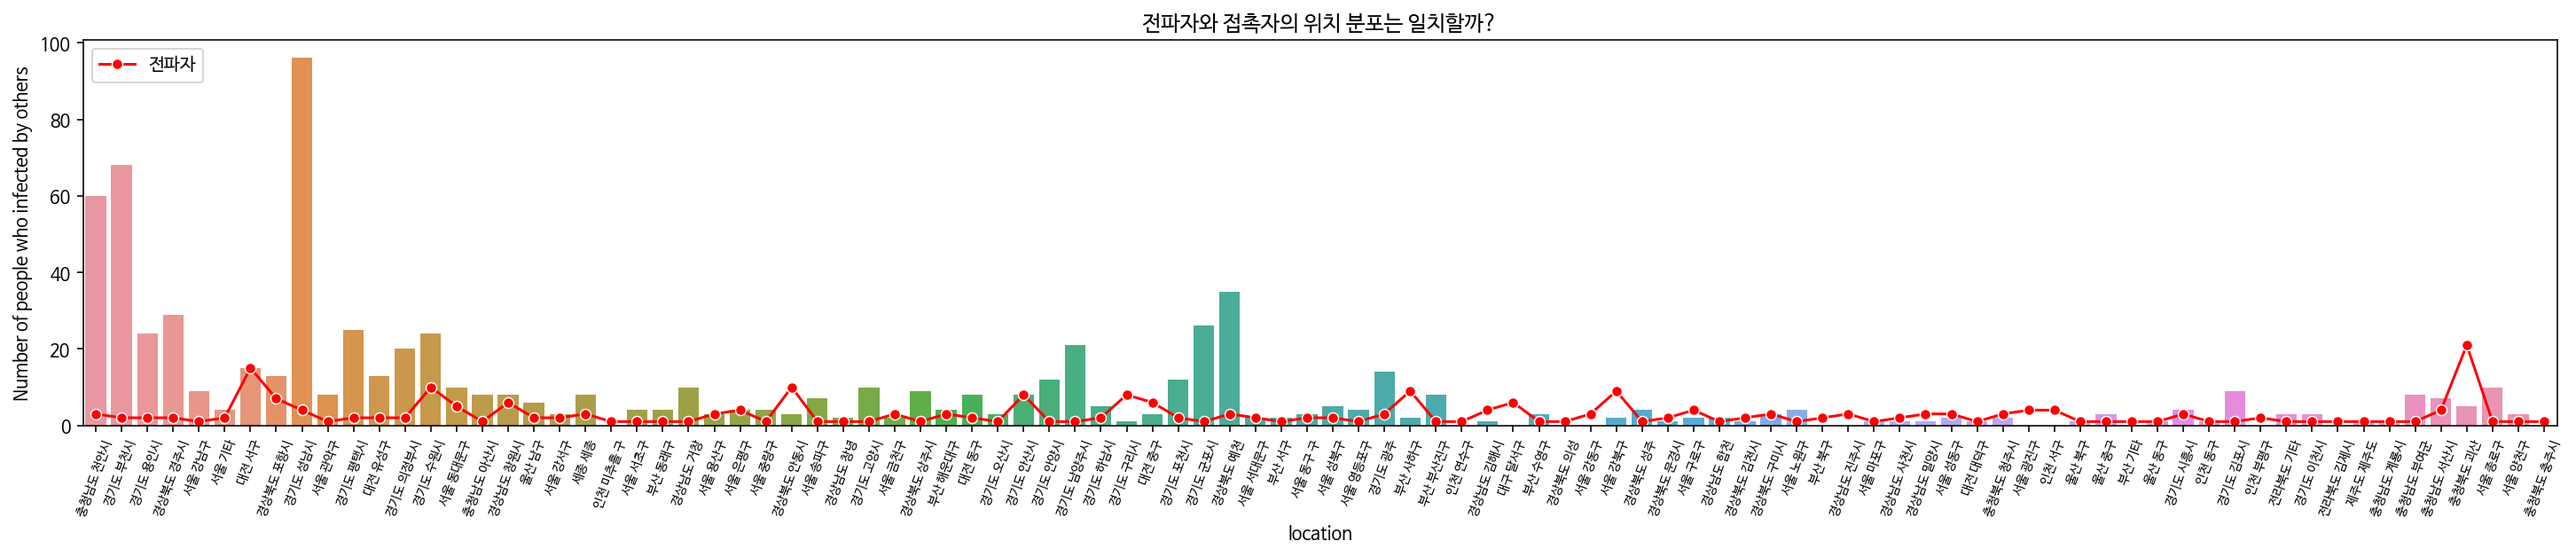

In [109]:
plt.figure(figsize=(25,4)) 
sns.lineplot(x='location', y='Number of people who have infected others', data=infection_merge, label='전파자',color='red',marker='o')
sns.barplot(x='location',y='Number of people who infected by others',data=infection_merge)
plt.title('전파자와 접촉자의 위치 분포는 일치할까?')
plt.xticks(rotation=70, fontsize = 7)
plt.show()

전파자와 접촉자의 위치 분포가 일치할지 그래프를 그려보았지만, 전혀 일치하지 않는 것을 확인할 수 있었고, 경기도 성남시 사람들이 접촉에 의해 감염이 많이 되었음에 반해 전파자 수는 매우 적다.